**Домашняя работа**

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
non_stac = pd.read_csv("Series/international-airline-passengers.csv")["Count"]
stac = pd.read_csv("Series/daily-total-female-births-in-cal.csv")["Count"]

1) Построим график нестационарного ряда "International airline passengers: monthly totals in thousands".

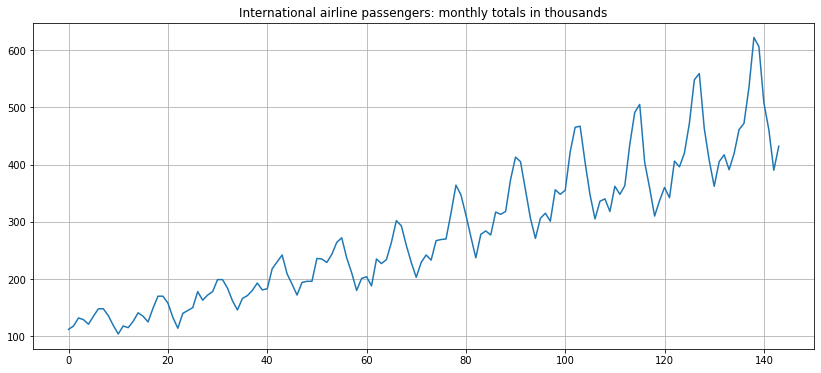

In [3]:
plt.figure(figsize=(14, 6))
plt.plot(non_stac)
plt.title("International airline passengers: monthly totals in thousands")
plt.grid()
plt.show()

На графике мы видим как тренд, так и сезонность, поэтому лучше выбрать модель, учитывающую оба этих фактора. В качестве такой модели выберем TEMA.

In [4]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)
    # вычисляем средние за сезон
    for j in range(n_seasons):
        sm = sum(series[slen * j : slen * j + slen]) # суммируем все значения внутри сезона
        season_averages.append(sm / float(slen))
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            # суммируем отклонения от средних по каждой i-ой компоненте каждого блока (сезона)
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        # усредняем
        seasonals[i] = sum_of_vals_over_avg / float(n_seasons)
    # получаем список средних значений каждой i-ой компоненты сезона (между сезонами)
    return seasonals

def tema(series, slen, alpha, beta, gamma, n_preds):
    result = []
    for i in range(len(series) + n_preds):
        # описание
        if i < len(series):
            val = series[i]
            # инициализация
            if len(result) == 0:
                smooth = val
                trend = (series[slen] - series[0]) / float(slen)
                seasonals = initial_seasonal_components(series, slen)
                result.append(smooth)
            else:
                last_smooth = smooth
                smooth = alpha * (val - seasonals[i % slen]) + (1 - alpha) * (smooth + trend)
                trend = beta * (smooth - last_smooth) + (1 - beta) * trend
                seasonals[i % slen] = gamma * (val - smooth) + (1 - gamma) * seasonals[i%slen]
                result.append(smooth + trend + seasonals[i % slen])
        # прогноз
        else:
            m = i - len(series) + 1
            result.append((smooth + m * trend) + seasonals[i % slen])
    return result

def plot_tema(ser, slen, alpha, beta, gamma, n_preds, ser_plot=None, title_append=None):
    if ser_plot is None:
        ser_plot = ser
    title = f"alpha={alpha}, beta={beta}, gamma={gamma}"
    if title_append is not None:
        title += " " + title_append
    t = tema(ser, slen, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_plot, color='blue',label='original')
        plt.plot(t[:len(ser)], color='red', linewidth='4', label='TEMA')
        plt.plot([x + len(ser) for x in range(-1, n_preds)], t[len(ser) - 1:], color='green', linewidth='4', label='TEMA prediction')
        plt.title(title)
        plt.legend()
        plt.show()
        
def mse_tema(X, *args):
    train = args[0]
    test = args[1]
    slen = args[2]
    alpha, beta, gamma = X
    res = tema(train, slen, alpha, beta, gamma, len(test))
    predictions = res[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

Построим прогноз на 24 месяца, пока без оценки качества и с произвольными значениями alpha, beta и gamma.

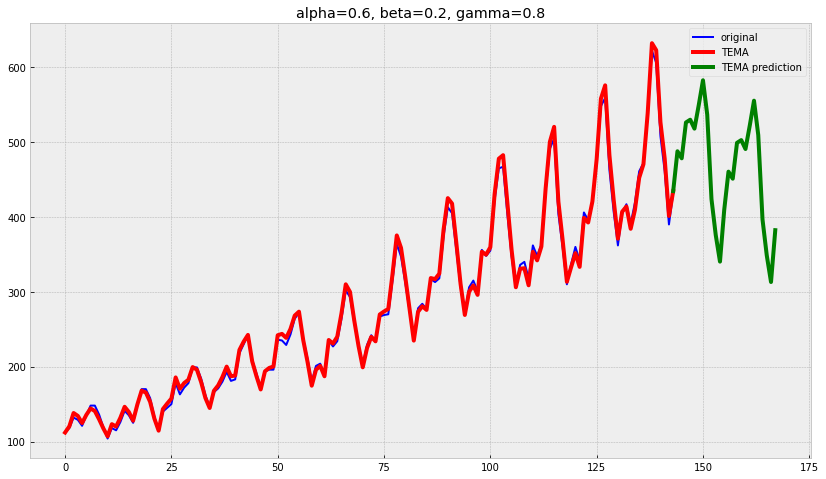

In [5]:
forecast = 24 # прогноз на 24 месяца
slen = 12     # сезонность
plot_tema(non_stac, slen, 0.6, 0.2, 0.8, forecast)

Разобьем выборку на train, test и val. Подберем параметры alpha, beta и gamma.

In [6]:
def train_test_val_split(ser, test_part, val_part):
    tc = int(len(ser) * test_part)
    vc = int(len(ser) * val_part)
    ac = len(ser) - tc - vc
    return ser[:ac], ser[ac : ac + tc], ser[-vc:]


train, test, val = train_test_val_split(non_stac, 0.13, 0.1)
opt = minimize(mse_tema, [0, 0, 0], args=(train, test, slen), bounds=((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(f"alpha: {alpha_opt}, beta: {beta_opt}, gamma: {gamma_opt}.")

alpha: 0.08960552464745795, beta: 0.06250141335225778, gamma: 1.0.


Построим график того, на чем проводился подбор параметров, и рассчитаем MSE.

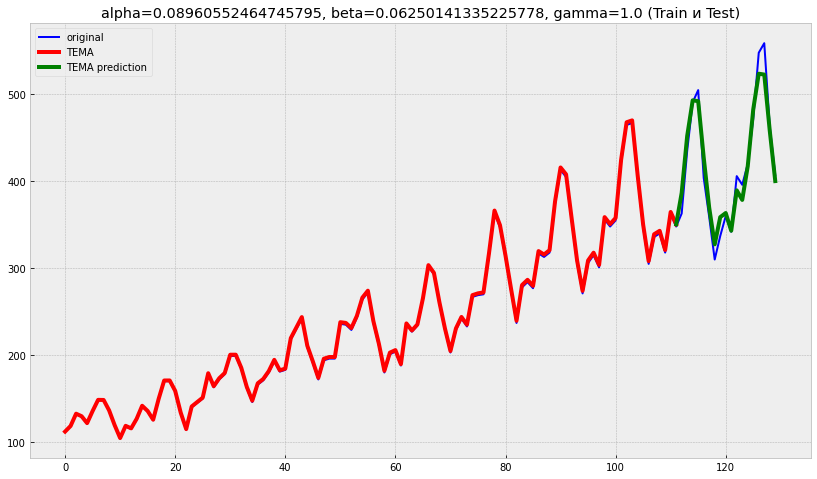

MSE: 285.27069444286735.


In [7]:
plot_tema(train, slen, alpha_opt, beta_opt, gamma_opt, n_preds=len(test), ser_plot=train.append(test), title_append="(Train и Test)")
print(f"MSE: {mse_tema(opt.x, train, test, slen)}.")

Теперь проверим результат на тех данных, которые не видел оптимизатор, и рассчитаем соответствующую MSE.

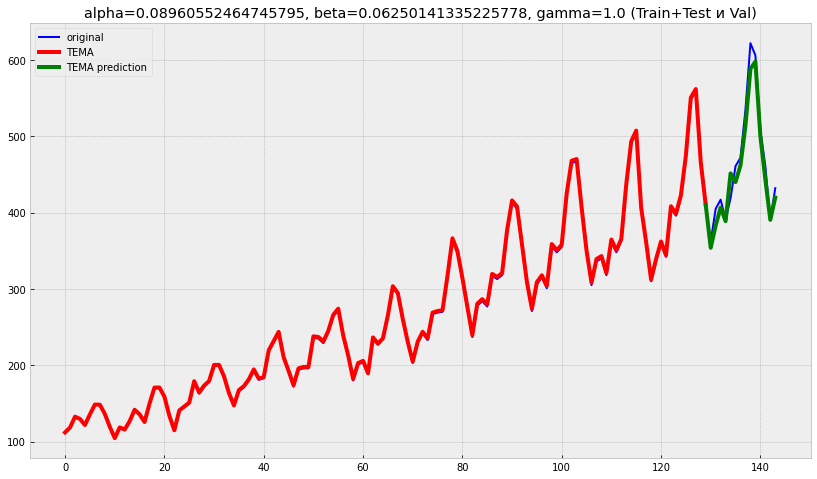

MSE: 313.9758711018946.


In [8]:
plot_tema(train.append(test), slen, alpha_opt, beta_opt, gamma_opt, n_preds=len(val), ser_plot=non_stac, title_append="(Train+Test и Val)")
print(f"MSE: {mse_tema(opt.x, train.append(test), val, slen)}.")

Как видим, тройное усреднение справилось довольно неплохо, хотя и MSE подросла в сравнении с той, относительно которой производился подбор параметров.

2) Построим график стационарного ряда "Daily total female births in California".

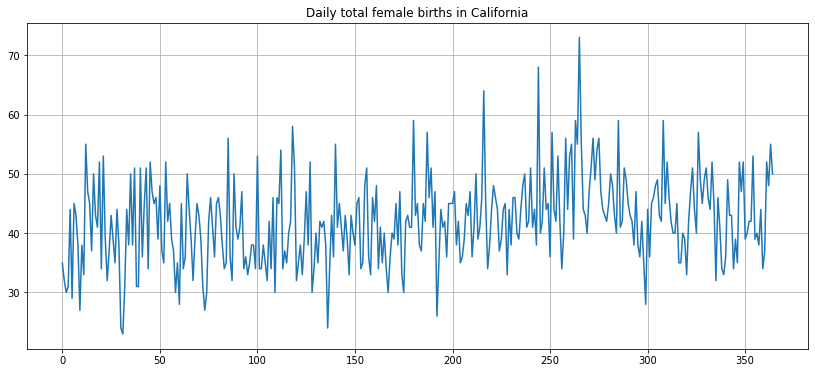

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(stac)
plt.title("Daily total female births in California")
plt.grid()
plt.show()

График стационарный - не имеет сезонности и тренда, поэтому нет смысла использовать DEMA или TEMA. Понятно, что методы MA, WMA покажут среднюю как только закончится окно). А EMA при alpha = 1 она идеально опишет и покажет нулевую RME просто скопировав значения. Проиллюстрируем это.

In [10]:
def ema(series, alpha, n_pred):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-2]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions[1:]), ignore_index=True)#, pd.Series(result)

def plot_ema(ser, alpha, n_preds, ser_plot=None, title_append=None):
    if ser_plot is None:
        ser_plot = ser
    title = f"alpha={alpha}"
    if title_append is not None:
        title += " " + title_append
    t = ema(ser, alpha, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_plot, color='blue',label='original')
        plt.plot(t[:len(ser)], color='red', linewidth='4', label='EMA')
        plt.plot([x + len(ser) for x in range(-1, n_preds)], t[len(ser) - 1:], color='green', linewidth='4', label='EMA prediction')
        plt.title(title)
        plt.legend()
        plt.show()
        
def mse_ema(X, *args):
    train = args[0]
    test = args[1]
    alpha = X[0]
    res = ema(train, alpha, len(test))
    predictions = res[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

Построим прогноз на 24 месяца, пока без оценки качества и с произвольным значением alpha.

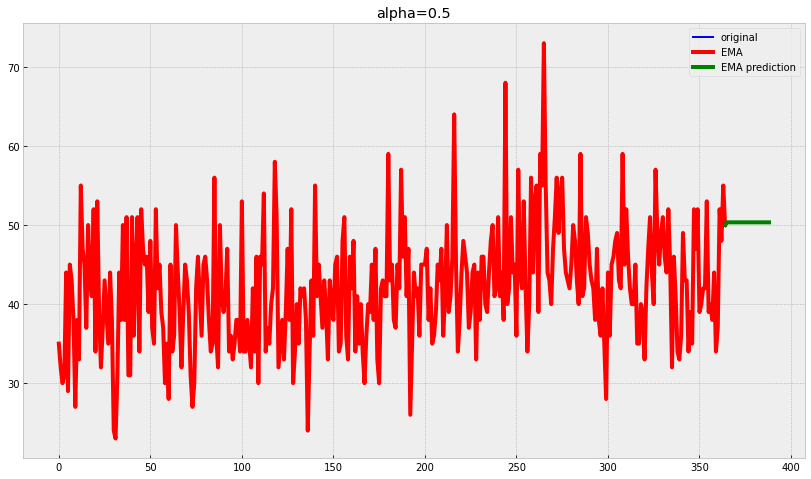

In [11]:
plot_ema(stac, 0.5, forecast)

Разобьем выборку на train, test и val. Подберем параметр alpha.

In [12]:
train, test, val = train_test_val_split(stac, 0.13, 0.1)
opt = minimize(mse_ema, 0, args=(train, test), bounds=((0, 1),))
alpha_opt = opt.x[0]
print(f"alpha: {alpha_opt}.")

alpha: 0.34492266601981847.


Построим график того, на чем проводился подбор параметров, и рассчитаем MSE.

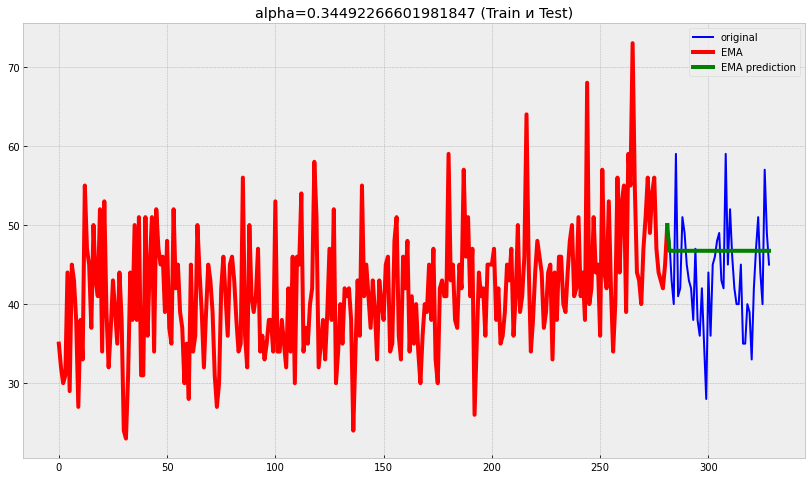

MSE: 50.090326352202595.


In [13]:
plot_ema(train, alpha_opt, n_preds=len(test), ser_plot=train.append(test), title_append="(Train и Test)")
print(f"MSE: {mse_ema(opt.x, train, test)}.")

Теперь проверим результат на тех данных, которые не видел оптимизатор, и рассчитаем соответствующую MSE.

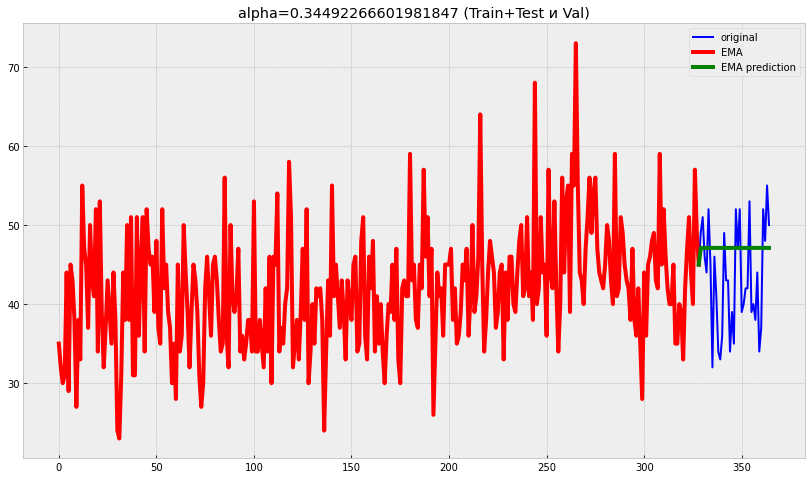

MSE: 57.50902360596466.


In [14]:
plot_ema(train.append(test), alpha_opt, n_preds=len(val), ser_plot=stac, title_append="(Train+Test и Val)")
print(f"MSE: {mse_ema(opt.x, train.append(test), val)}.")

Ожидаемый результат: EMA довольно бытро сходится к среднему.

In [15]:
def ma(series, n, n_pred):
    new_series = series.rolling(n).mean()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-n:].mean()]), ignore_index=True)
    return new_series

def wma(series, weights, n_pred):
    n = len(weights)
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
        
    new_series = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series(np.dot(new_series[-n:], weights) / weights.sum()), ignore_index=True)
    return new_series

def plot_ma(ser, lag, n_preds, ser_plot=None, title_append=None):
    if ser_plot is None:
        ser_plot = ser
    title = ""
    if title_append is not None:
        title += " " + title_append
    t = ma(ser, lag, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_plot, color='blue',label='original')
        plt.plot(t[:len(ser)], color='red', linewidth='4', label='MA')
        plt.plot([x + len(ser) for x in range(-1, n_preds)], t[len(ser) - 1:], color='green', linewidth='4', label='MA prediction')
        plt.title(title)
        plt.legend()
        plt.show()
        
def plot_wma(ser, weights, n_preds, ser_plot=None, title_append=None):
    if ser_plot is None:
        ser_plot = ser
    title = ""
    if title_append is not None:
        title += " " + title_append
    t = wma(ser, weights, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_plot, color='blue',label='original')
        plt.plot(t[:len(ser)], color='red', linewidth='4', label='WMA')
        plt.plot([x + len(ser) for x in range(-1, n_preds)], t[len(ser) - 1:], color='green', linewidth='4', label='WMA prediction')
        plt.title(title)
        plt.legend()
        plt.show()
        
def mse_ma(*args):
    train = args[0]
    test = args[1]
    lag = args[2]
    res = ma(train, lag, len(test))
    predictions = res[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

def mse_wma(*args):
    train = args[0]
    test = args[1]
    weights = args[2]
    res = wma(train, weights, len(test))
    predictions = res[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

Построим графики MA и WMA.

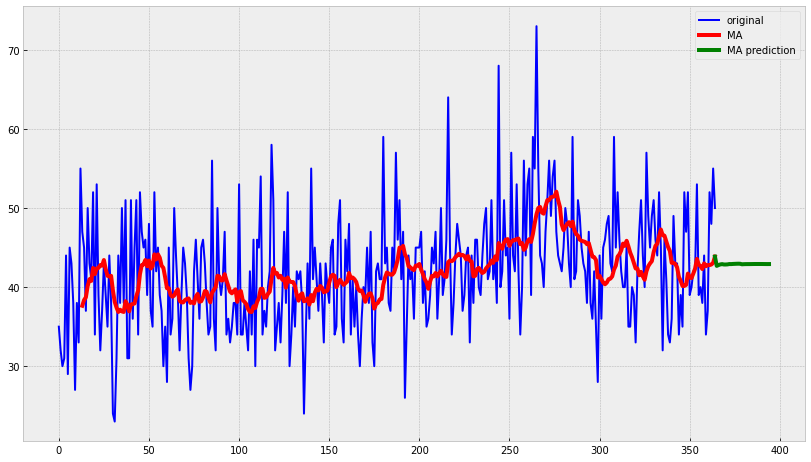

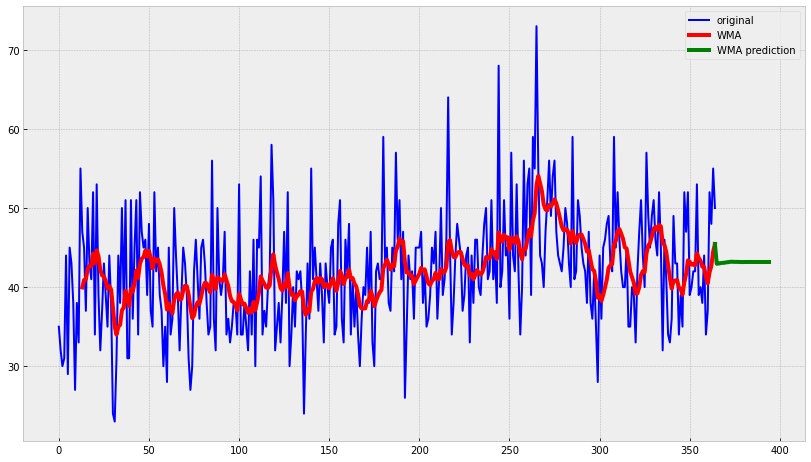

In [16]:
lag = 14      # окно в 14 дней
forecast = 30 # прогноз на 30 дней
weights = [2, 3, 5, 7, 13, 17, 19, 23, 29, 31, 37, 39, 41, 43]
plot_ma(stac, lag, forecast)
plot_wma(stac, weights, forecast)

Из параметров, которые можно оптимизировать у MA и WMA - это размер окна и веса. Однако, очевидно, что качество прогноза для стационарного ряда будет выше при большем размере окна и большем кол-ве весов. Поэтому для их сравнения нет необходимости подбирать их через оптимизатор. Положим для обеих моделей одинаковые значения размера окна и кол-ва весов.

Разделим выборки на train и test, построим графики и рассчитаем MSE.

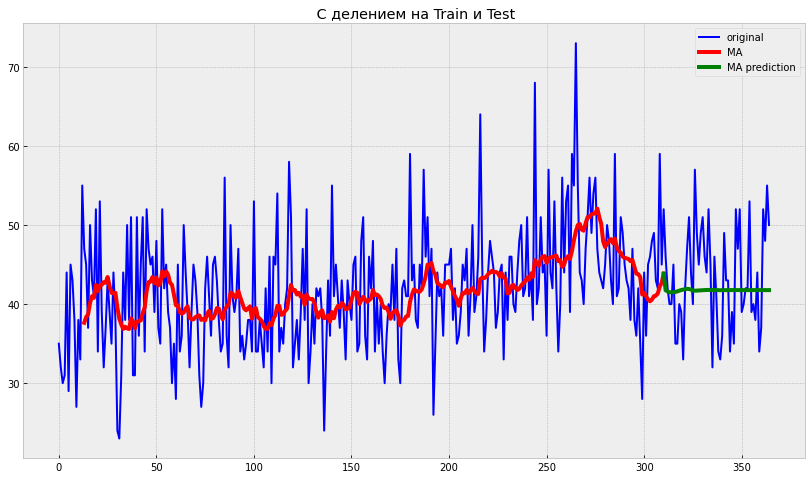

MSE: 41.21727963166645.


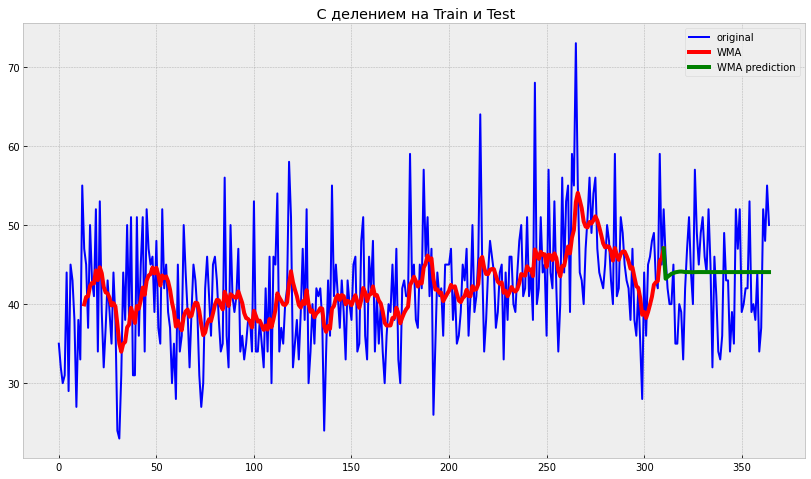

MSE: 40.56156494067389.


In [17]:
train, test, _ = train_test_val_split(stac, 0.15, 0)
plot_ma(train, lag, n_preds=len(test), ser_plot=stac, title_append="С делением на Train и Test")
print(f"MSE: {mse_ma(train, test, lag)}.")
plot_wma(train, weights, n_preds=len(test), ser_plot=stac, title_append="С делением на Train и Test")
print(f"MSE: {mse_wma(train, test, weights)}.")

Собственно, получили то, что и ожидали: за пределами окна MA и WMA сходятся к среднему.